In [ ]:
!unzip dataset6.zip -d ./

In [ ]:
!pip install catboost

In [4]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from joblib import dump, load

In [5]:
df = pd.read_csv('/content/TCGA_GBM_LGG_Mutations_all.csv')

# EDA

### Пропущенные знаечния, удаление и преобразование столбцов

In [6]:
df.tail(3)

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
859,GBM,TCGA-GBM,TCGA-28-1746,Female,77 years 178 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
860,GBM,TCGA-GBM,TCGA-32-2491,Male,63 years 121 days,Glioblastoma,white,NOT_MUTATED,MUTATED,NOT_MUTATED,...,NOT_MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
861,GBM,TCGA-GBM,TCGA-06-2557,Male,76 years 221 days,Glioblastoma,black or african american,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

все данные - категориальные

вместо None пропуски обозначаются "--",  уберу строки, которые содержат "--"

In [8]:
df[df['Age_at_diagnosis'].str.contains('--')].shape[0]

5

In [9]:
df = df.replace('--', None)
df.isnull().mean().sort_values(ascending=False)
df[df.isnull().any(axis=1)]

,Grade,Project,Case_ID,Gender,Age_at_diagnosis,Primary_Diagnosis,Race,IDH1,TP53,ATRX,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
41,LGG,TCGA-LGG,TCGA-R8-A6YH,None,None,None,None,MUTATED,MUTATED,MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
437,LGG,TCGA-LGG,TCGA-W9-A837,Male,None,"Oligodendroglioma, NOS",white,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
671,GBM,TCGA-GBM,TCGA-28-2501,None,None,None,None,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
706,GBM,TCGA-GBM,TCGA-28-2510,None,None,None,None,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
794,GBM,TCGA-GBM,TCGA-16-1048,None,None,None,None,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [10]:
df = df.dropna(axis=0, how='any')

преобразую возраст в числовой признак, затем создам дополнительную колонку с возрастными категориями:
14 - 35

36 - 45

46 - 55

56 - 65

66 - 89

In [11]:
df['age'] = df['Age_at_diagnosis'].apply(lambda x: int(x.split(' ')[0]))

In [12]:
def get_age_group(x):
    if (x >= 14) and (x <= 35):
        return '14-35'
    elif (x > 35) and (x <= 45):
        return '36-45'
    elif (x > 45) and (x <= 55):
        return '46-55'
    elif (x > 55) and (x <= 65):
        return '56-65'
    else:
        return '66-89'

df['age_range'] = df['age'].apply(lambda x: get_age_group(x))

In [13]:
df = df.drop(columns=['Project', 'Case_ID'])

### Визуализация

Визуализация зависимости класса глиомы от возраста

In [14]:
age_percentage_df = pd.crosstab(df['age_range'], df['Grade'], normalize='index') * 100

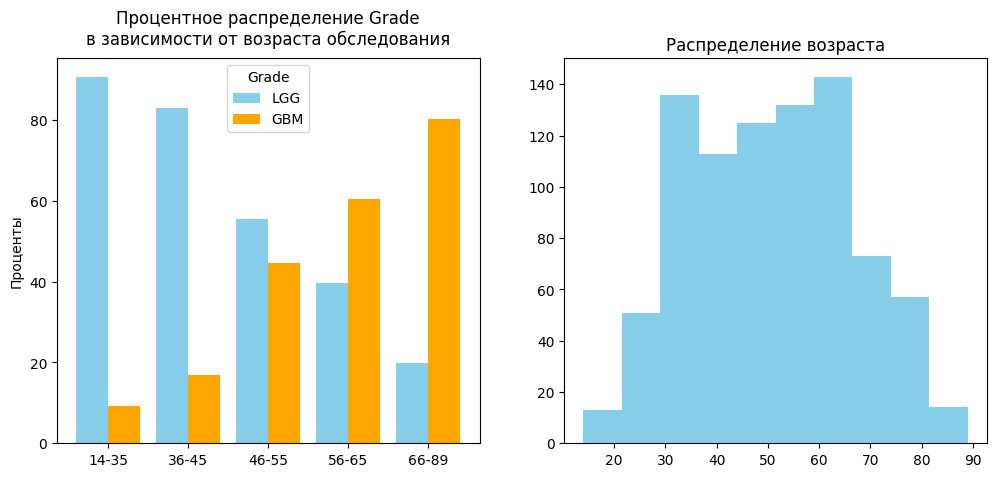

In [15]:
fif, axes = plt.subplots(1, 2, figsize=(12, 5))
X_axis = np.arange(len(list(age_percentage_df.index)))

axes[0].bar(X_axis - 0.2, age_percentage_df['LGG'], 0.4, color = 'skyblue', label='LGG')
axes[0].bar(X_axis + 0.2, age_percentage_df['GBM'], 0.4, color = 'orange', label='GBM')

axes[0].set_xticks(X_axis)
axes[0].set_xticklabels(list(age_percentage_df.index))

axes[0].set_title('Процентное распределение Grade\nв зависимости от возраста обследования', loc='center', pad=10)
axes[0].set_ylabel('Проценты')
axes[0].legend(title='Grade')

axes[1].hist(df['age'], color='skyblue')
axes[1].set_title('Распределение возраста')

plt.show()

визуализация зависимости класса глиомы от расы

In [16]:
age_race_df = pd.crosstab(df['Race'], df['Grade'], normalize='index') * 100

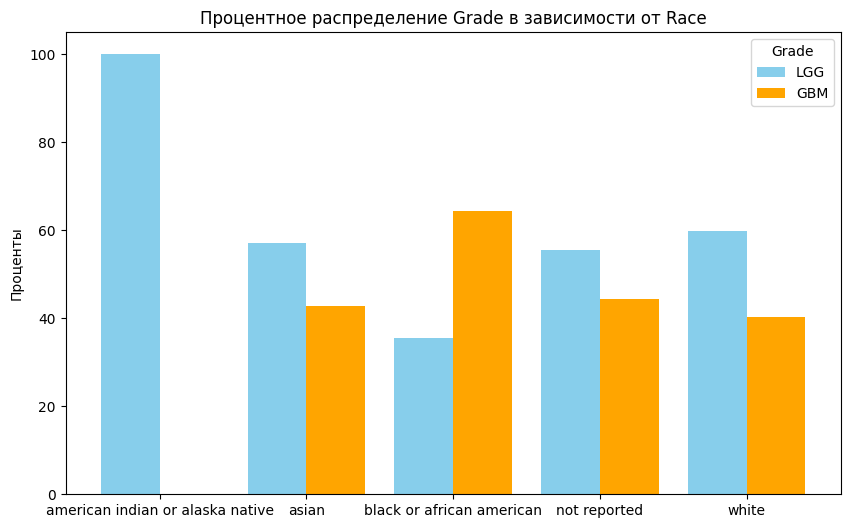

In [17]:
plt.figure(figsize=(10, 6))
X_axis = np.arange(len(list(age_race_df.index)))

plt.bar(X_axis - 0.2, age_race_df['LGG'], 0.4, color = 'skyblue', label='LGG')
plt.bar(X_axis + 0.2, age_race_df['GBM'], 0.4, color = 'orange', label='GBM')

plt.xticks(X_axis, list(age_race_df.index))

plt.title('Процентное распределение Grade в зависимости от Race')
plt.ylabel('Проценты')
plt.legend(title='Grade')
plt.show()

In [18]:
age_race_df = pd.crosstab(df['Race'], df['age_range'], normalize='index') * 100

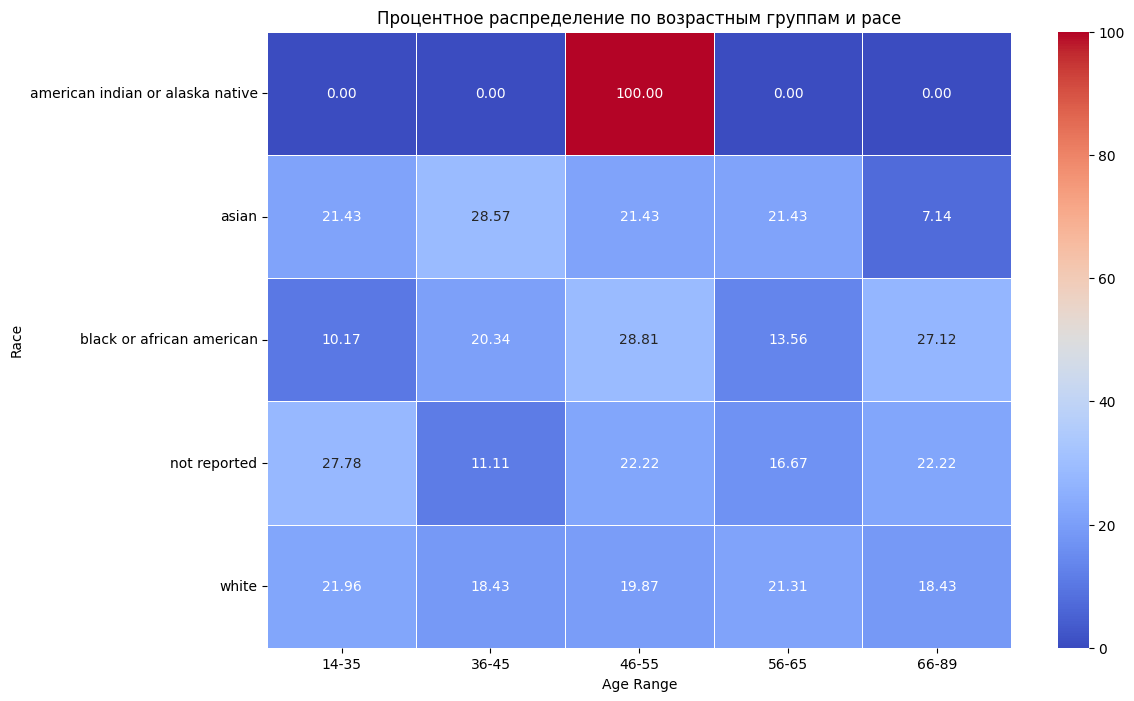

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(age_race_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.xlabel('Age Range')
plt.ylabel('Race')
plt.title('Процентное распределение по возрастным группам и расе')

plt.show()

In [20]:
for race in list(df['Race'].unique()):
    age = df[df['Race'] == race]['age'].mean()
    print(f'{race}: {round(age, 2)}')

white: 50.27
asian: 47.93
black or african american: 53.29
not reported: 49.78
american indian or alaska native: 47.0


есть веротяность, что шанс возникновения глиомы класса GBM выше у расы "black or african american", так как средний возраст у них выше

Посмотрим корреляцию категореальных молекулярных факторов с классификацией глиомы

In [21]:
contingency_tables = {}
for column in df.columns[5:25]:
    contingency_tables[column] = pd.crosstab(df['Grade'], df[column])

ch2_dict = {}

for column, table in contingency_tables.items():
    chi2, p, _, _ = chi2_contingency(table)
    V_Cramer = (chi2 / ((min(table.shape) - 1) * table.sum().sum())) ** 0.5

    ch2_dict[column] = [round(chi2, 6), round(p, 6), round(V_Cramer, 8)]

ch2_df = pd.DataFrame(ch2_dict, index=["Chi2 Statistic", "P-value", "Cramer's V"])
ch2_df

,IDH1,TP53,ATRX,PTEN,EGFR,CIC,MUC16,PIK3CA,NF1,PIK3R1,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
Chi2 Statistic,429.248344,19.976295,80.360739,113.638838,48.462901,78.185965,11.870993,0.392885,7.153866,8.596433,27.475208,31.387212,27.026171,0.0,1.136189,7.992428,10.447703,9.406132,0.619819,7.500830
P-value,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000570,0.530787,0.007480,0.003368,0.000000,0.000000,0.000000,1.0,0.286459,0.004697,0.001228,0.002163,0.431115,0.006167
Cramer's V,0.707724,0.152675,0.306219,0.364144,0.237801,0.302047,0.117694,0.021411,0.091365,0.100154,0.179052,0.191375,0.177583,0.0,0.036411,0.096572,0.110413,0.104765,0.026893,0.093554


In [22]:
columns = list(df.columns)
columns.remove('age')
columns.remove('Age_at_diagnosis')

In [23]:
df_stat = pd.DataFrame(columns=columns)
for column_row in columns:

    ch2_dict = {}
    for column_col in columns:
        table = pd.crosstab(df[column_col], df[column_row])
        chi2, p, _, _ = chi2_contingency(table)
        V_Cramer = (chi2 / ((min(table.shape) - 1) * table.sum().sum())) ** 0.5
        ch2_dict[column_col] = [V_Cramer]
    ch2_df = pd.DataFrame(ch2_dict)
    df_stat = pd.concat([df_stat, ch2_df])

df_stat.index = columns

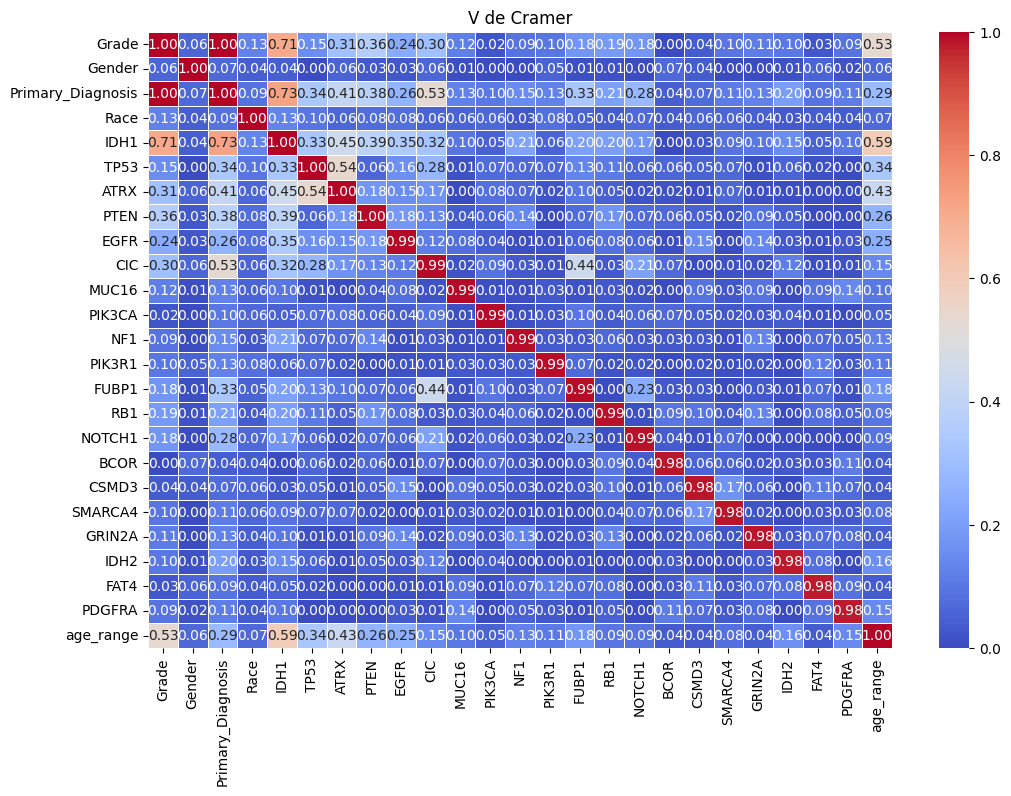

In [24]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_stat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.title('V de Cramer')

plt.show()

Primary_diagnosis, FUBP1 надо удалить из данных

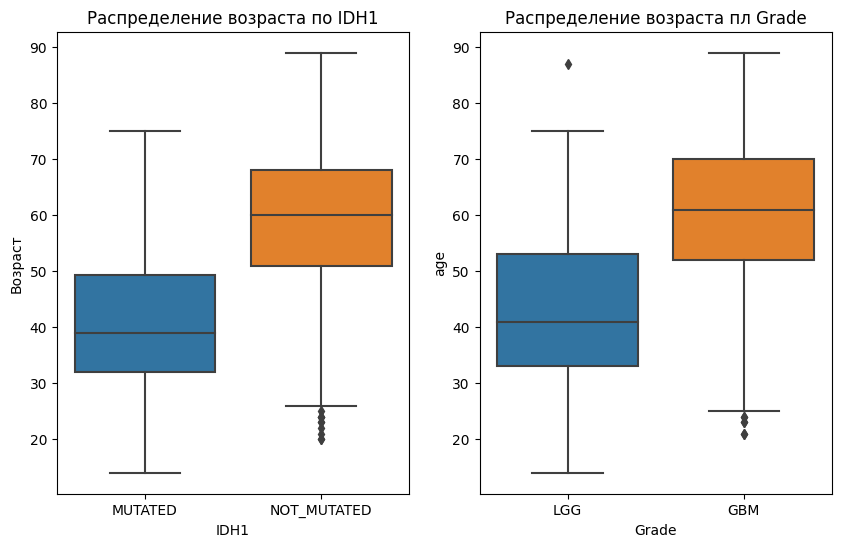

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
sns.boxplot(x='IDH1', y='age', data=df, ax=axes[0])
sns.boxplot(x='Grade', y='age', data=df, ax=axes[1])

axes[0].set_title('Распределение возраста по IDH1')
axes[1].set_title('Распределение возраста пл Grade')
axes[0].set_xlabel('IDH1')
axes[0].set_ylabel('Возраст')
plt.show()


In [26]:
df = df.drop(columns=['Primary_Diagnosis', 'FUBP1', 'Age_at_diagnosis', 'age_range'])

In [ ]:
df.head(1)

# Преобразование данных в числовые

In [ ]:
df.columns

In [29]:
def get_binary_columns(columns, df):
    for column in columns:
        label_encoder = LabelEncoder()
        df[column] = label_encoder.fit_transform(df[column])
    return df

In [30]:
bynary_columns = ['Gender', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR',
       'CIC', 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'RB1', 'NOTCH1', 'BCOR',
       'CSMD3', 'SMARCA4', 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']

df = get_binary_columns(bynary_columns, df)

In [31]:
df = pd.get_dummies(df, columns=['Race'])

In [32]:
df['Grade'] = df['Grade'].replace({'GBM': 1, 'LGG': 0})

нормализуем возраст

In [33]:
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']])

# Построение алгоритмов

In [34]:
y = df['Grade']
X = df.drop(columns='Grade')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
models = {
    'CatBoost': [CatBoostClassifier(random_state=42, verbose=0), {'iterations': [100, 200, 300],
                                                                    'learning_rate': [0.01, 0.1, 0.2],
                                                                    'depth': [4, 6, 8],
                                                                    'l2_leaf_reg': [1, 3, 5]}],
    'SVM': [SVC(), {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}],
    'RandomForest': [RandomForestClassifier(random_state=42), {'n_estimators': [10, 50, 100, 200],
                                                                'max_depth': [None, 10, 20, 30],
                                                                'min_samples_split': [2, 5, 10],
                                                                'min_samples_leaf': [1, 2, 4]}],
    'GradintBoosting': [GradientBoostingClassifier(random_state=42), {'n_estimators': [10, 50, 100, 200],
                                                                        'max_depth': [3, 5, 7, 9],
                                                                        'learning_rate': [0.01, 0.1, 0.2],
                                                                        'min_samples_split': [2, 5, 10],
                                                                        'min_samples_leaf': [1, 2, 4]}]
}

In [37]:
def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

create_folder_if_not_exists("models")

In [38]:
def traing_models(models):
    df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy'])
    for model, params in models.items():
        rsh = HalvingGridSearchCV(estimator=params[0], param_grid=params[1], random_state=42)
        rsh.fit(X, y)

        if model == 'CatBoost':
            best_cb_model = rsh.best_estimator_
            best_cb_model.save_model(f'models/{model}.cbm', format='cbm')
        else:
            best = rsh.best_estimator_
            dump(best, f'models/{model}.joblib')

        y_pred = rsh.predict(X_test)
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        new_dict = {}
        for key in ['0', '1']:
            if key in report_dict:
                new_dict[key] = report_dict[key]
                new_dict[key]['accuracy'] = report_dict['accuracy']

        report_df = pd.DataFrame(new_dict).transpose()
        report_df = report_df.drop(columns='support')
        multi_index = pd.MultiIndex.from_product([[model], report_df.index], names=['Model', 'Class'])
        report_df.index = multi_index
        df = pd.concat([df, report_df])
    return df

df = traing_models(models)
df

,precision,recall,f1-score,accuracy
"(CatBoost, 0)",0.975904,0.843750,0.905028,0.901163
"(CatBoost, 1)",0.831461,0.973684,0.896970,0.901163
"(SVM, 0)",0.964286,0.843750,0.900000,0.895349
"(SVM, 1)",0.829545,0.960526,0.890244,0.895349
"(RandomForest, 0)",0.976471,0.864583,0.917127,0.912791
"(RandomForest, 1)",0.850575,0.973684,0.907975,0.912791
"(GradintBoosting, 0)",0.964286,0.843750,0.900000,0.895349
"(GradintBoosting, 1)",0.829545,0.960526,0.890244,0.895349


В этом случае основная задача — обнаруживать все возможные случаи класса 1 (класс наиболее опасной глиомы). Ошибочная классификация LGG как GBM не будет иметь серьезных последствий. Поэтому при выборе модели особое внимание следует уделить метрике recall.